* torchvision : Contains datasets, model architectures and image transformations often used for computer vision problems.
* torchvision.datasets : Here you'll find many example computer vision datasets for a range of problems from image classification, object detection, image captioning, video classification and more. It also contains a series of base classes for making custom datasets.
* torchvision.models : This module contains well-performing and commonly used computer vision model architectures implemented in PyTorch, you can use these with your own problems.
* torchvision.transforms : Often images need to be transformed (turned into numbers/processed/augmented) before being used with a model, common image transformations are found here.
* torch.utils.data.Dataset : Base dataset class for PyTorch.
* torch.utils.data.DataLoader : Creates a Python iteralbe over a dataset (created with torch.utils.data.Dataset).

In [1]:
import torch
from torch import nn
import torchvision 
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [2]:
# Fashion Mnist
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

(-0.5, 27.5, 27.5, -0.5)

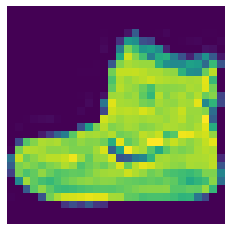

In [6]:
image, label = train_data[0]
plt.imshow(image.squeeze())
plt.axis(False)

#DENSE MODEL

In [7]:
from torch.utils.data import DataLoader



BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data, 
                              batch_size = BATCH_SIZE,
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data, 
                             batch_size = BATCH_SIZE,
                             shuffle  = False)
train_features_batch, train_labels_batch = next(iter(train_dataloader))

In [8]:
train_features_batch.shape

torch.Size([32, 1, 28, 28])

In [9]:
from torch import nn
class FashionMNISTModel(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_shape),
        nn.ReLU()
    )
  def forward(self, x):
    return self.layer_stack(x)

In [10]:
device = "cuda" if torch.cuda.is_available else "cpu"

In [11]:
torch.manual_seed(42)
model_0 = FashionMNISTModel(
    input_shape = 784,
    hidden_units = 10,
    output_shape = len(class_to_idx)
).to(device)

model_0

FashionMNISTModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [12]:
dummy_x = torch.rand([32, 1, 28, 28])
dummy_x = dummy_x.to(device)
model_0(dummy_x).shape

torch.Size([32, 10])

In [13]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]],
                     device='cuda:0')),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163], device='cuda:0')),
             ('layer_stack.3.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0

In [14]:
def accuracy_fn(y_pred, y_test):
  correct = torch.eq(y_pred, y_test).sum().item()
  acc = (correct/len(y_pred))*100
  return acc


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = 1e-4)

In [15]:
from timeit import default_timer as timer
def print_train_time(start : float, 
                     end: float, 
                     device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device} : {total_time:.3f} seconds")
  return total_time

In [16]:
from tqdm.auto import tqdm
torch.manual_seed(42)
train_time_start_on_gpu = timer()
epochs = 1
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epochs}\n------")
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    X = X.to(device)
    y = y.to(device)
    y_pred = model_0(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    test_loss, test_acc = 0,0
    model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      X_test = X_test.to(device)
      y_test = y_test.to(device)
      test_pred = model_0(X_test)
        
      test_loss += loss_fn(test_pred, y_test)
        
      test_acc += accuracy_fn(y_pred = test_pred.argmax(dim = 1), y_test = y_test)
      #print(accuracy_fn(y_pred = test_pred.argmax(dim = 1), y_test = y_test))
    test_acc /= len(test_dataloader)
  print(f"\n Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
  
train_time_end_on_gpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_gpu ,  end = train_time_end_on_gpu , device = device)


   




  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1
------

 Train loss: 2967.2087 | Test loss: 390.1232, Test acc: 60.9225
Train time on cuda : 12.932 seconds


In [17]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X = X.to(device)
      y = y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc  += accuracy_fn(y_pred = y_pred.argmax(dim = 1), y_test = y)

      acc  /= len(data_loader)

  return {
      "model_loss" : loss.item(),
      "model_acc" : acc
  }

model_0_results = eval_model(model = model_0,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)
model_0_results

{'model_loss': 390.1231689453125, 'model_acc': 0.24016092119252233}

#CNN MODEL


In [18]:
class CNN_(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape, out_channels = hidden_units,
                  kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
      )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 490,
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x



In [19]:
torch.manual_seed(42)
model_2 = CNN_(input_shape = 1,
               hidden_units = 10,
               output_shape = len(class_to_idx)).to(device)


In [20]:
rand_image_tensor = torch.randn(size = (32,1,28,28))
rand_image_tensor.shape
model_2(rand_image_tensor.to(device))[:1]

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<SliceBackward0>)

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2.parameters(),
                             lr = 0.01)

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from tqdm.auto import tqdm
torch.manual_seed(42)
train_time_start_on_gpu = timer()
epochs = 20
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epochs}\n------")
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    model_2.train()
    X = X.to(device)
    y = y.to(device)
    y_pred = model_2(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    test_loss, test_acc = 0,0
    model_2.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      X_test = X_test.to(device)
      y_test = y_test.to(device)
      test_pred = model_2(X_test)
        
      test_loss += loss_fn(test_pred, y_test)
        
      test_acc += accuracy_fn(y_pred = test_pred.argmax(dim = 1), y_test = y_test)
      #print(accuracy_fn(y_pred = test_pred.argmax(dim = 1), y_test = y_test))
    test_acc /= len(test_dataloader)
  print(f"\n Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
  
train_time_end_on_gpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_gpu ,  end = train_time_end_on_gpu , device = device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 20
------

 Train loss: 682.6428 | Test loss: 118.9779, Test acc: 86.2320
Epoch: 20
------

 Train loss: 675.9382 | Test loss: 118.1364, Test acc: 86.3518
Epoch: 20
------

 Train loss: 657.7328 | Test loss: 119.4517, Test acc: 85.8427
Epoch: 20
------

 Train loss: 657.3122 | Test loss: 117.7593, Test acc: 86.2320
Epoch: 20
------

 Train loss: 651.3486 | Test loss: 116.7844, Test acc: 86.4716
Epoch: 20
------

 Train loss: 652.5165 | Test loss: 119.7415, Test acc: 86.1322
Epoch: 20
------

 Train loss: 648.3035 | Test loss: 120.9676, Test acc: 85.7129
Epoch: 20
------

 Train loss: 652.9261 | Test loss: 114.1755, Test acc: 86.3818
Epoch: 20
------

 Train loss: 648.7134 | Test loss: 116.2420, Test acc: 86.6114
Epoch: 20
------

 Train loss: 659.8191 | Test loss: 123.0888, Test acc: 85.7728
Epoch: 20
------

 Train loss: 642.0765 | Test loss: 116.4870, Test acc: 86.8411
Epoch: 20
------

 Train loss: 649.1337 | Test loss: 114.8388, Test acc: 86.3419
Epoch: 20
------

 Train los

In [24]:
def make_prediction(model: torch.nn.Module,
                    data: list,
                    device: torch.device = device):
  model = model.to(device)
  model.eval()
  pred_probs = []
  with torch.inference_mode():
    for sample in data:
      sample = sample.to(device)
      pred_logits = model(sample)
      pred_prob = torch.softmax(pred_logits.squeeze(), dim = 0)
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)


In [26]:
import random
torch.manual_seed(42)

In [49]:
random_idx = torch.randint(low = 0, high = 300, size = (1,1))
random_idx

tensor([[198]])

In [55]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [56]:
import numpy as np

In [59]:
label  = np.arange(0,10)
label_name = ['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

tensor(5, device='cuda:0')
Predict: Sandal
Truth: Sandal


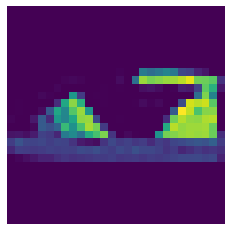

In [105]:
X_mark, y_mark = 0, 0
y_ = 0
for idx,(X, y) in enumerate(test_dataloader):
  if idx == random_idx.item():
    model_2.eval()
    X = X.to(device)
    y = y.to(device)
    y_logits = model_2(X)
    y_pred = y_logits.argmax(dim = 1)
    X_mark = X
    y_mark = y_pred
    y_ = y


random_batch = torch.randint(low = 0, high = 32, size = (1,1))
random_batch = random_batch.item()
X_mark = X_mark.cpu()
plt.imshow(X_mark[random_batch].squeeze())
plt.axis(False)
print(y_mark[random_batch])
for i in range(10):
  if y_mark[random_batch].item() == i:
    print(f"Predict: {label_name[i]}")
    print(f"Truth: {label_name[y_[random_batch]]}")

  

In [107]:
torch.save(obj = model_2.state_dict(),
           f = '/content/CNN/CNN_.pt')

In [109]:
torch.manual_seed(42)
loaded_model_2 = CNN_(input_shape = 1,
                      hidden_units = 10,
                      output_shape = 10)


loaded_model_2.load_state_dict(torch.load(f = '/content/CNN/CNN_.pt'))

<All keys matched successfully>

In [110]:
loaded_model_2.to(device)

CNN_(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)